In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
import torch.optim as optim
import seaborn as sns
import random as rand

sns.set()

Text(0, 0.5, 'Temperature')

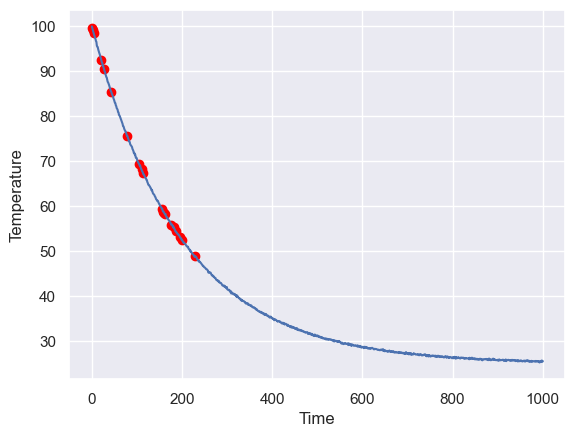

In [2]:
# Newtons Cooling Law
def f(t, y):
  r = 0.005
  y_env = 25
  return r*(y_env - y)

y0 = 100
t0 = 0

t_values = np.linspace(0, 1000, 1000)
dt = t_values[1] - t_values[0]

t_data = [t0]
y_data = [y0]

for t in t_values[1:]:
  y_n = y_data[-1] + f(t_data[-1], y_data[-1]) * dt
  y_data.append(y_n)
  t_data.append(t)

y_data, t_data = np.array(y_data), np.array(t_data)

# Add Gaussian noise to the solution
noise_level = 0.1 # Adjust the noise level as needed
noise = np.random.normal(loc=0, scale=noise_level, size=y_data.shape)
noisy_data = y_data + noise


# Get a random sample of 100 data points
n_data = 20
data_till = 250
early_sample = noisy_data[:data_till]
early_sample_t = t_data[:data_till]
random_indices = np.random.choice(np.arange(early_sample.shape[0]), size=n_data, replace=False)
random_sample = early_sample[random_indices]
random_t = early_sample_t[random_indices]


plt.scatter(random_t, random_sample, c='red')
plt.plot(t_data, noisy_data)
plt.xlabel('Time')
plt.ylabel('Temperature')

Epoch [100/3000], Loss: 97.6267
Epoch [200/3000], Loss: 7.4509
Epoch [300/3000], Loss: 24.6231
Epoch [400/3000], Loss: 3.1778
Epoch [500/3000], Loss: 0.3426
Epoch [600/3000], Loss: 0.8478
Epoch [700/3000], Loss: 0.2149
Epoch [800/3000], Loss: 0.1996
Epoch [900/3000], Loss: 4.3802
Epoch [1000/3000], Loss: 3.2824
Epoch [1100/3000], Loss: 0.9535
Epoch [1200/3000], Loss: 5.3768
Epoch [1300/3000], Loss: 3.0749
Epoch [1400/3000], Loss: 3.2482
Epoch [1500/3000], Loss: 0.1522
Epoch [1600/3000], Loss: 3.0983
Epoch [1700/3000], Loss: 6.2789
Epoch [1800/3000], Loss: 3.3785
Epoch [1900/3000], Loss: 5.9115
Epoch [2000/3000], Loss: 2.0396
Epoch [2100/3000], Loss: 25.1623
Epoch [2200/3000], Loss: 5.9969
Epoch [2300/3000], Loss: 0.0706
Epoch [2400/3000], Loss: 4.9731
Epoch [2500/3000], Loss: 5.2597
Epoch [2600/3000], Loss: 0.0929
Epoch [2700/3000], Loss: 0.6776
Epoch [2800/3000], Loss: 6.4274
Epoch [2900/3000], Loss: 0.0833
Epoch [3000/3000], Loss: 7.1145
Parameter containing:
tensor([0.0041], require

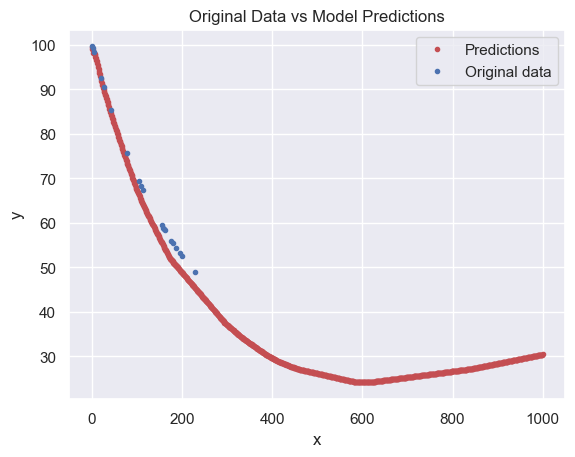

In [5]:

# Check if the device is available
device = torch.device('cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 50).to(device)  # Input size: 1, output size: 50
        self.fc2 = nn.Linear(50, 50).to(device)  # Input size: 50, output size: 50
        self.fc3 = nn.Linear(50, 50).to(device)  # Input size: 50, output size: 50
        self.fc4 = nn.Linear(50, 1).to(device)   # Input size: 50, output size: 1
        self.r = nn.Parameter(data=torch.tensor([0.])).to(device)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Convert data to PyTorch tensors and move to device
x_data = torch.tensor(random_t, dtype=torch.float32).view(-1, 1).to(device)  # Reshape to (n_samples, 1)
y_data = torch.tensor(random_sample, dtype=torch.float32).view(-1, 1).to(device)  # Reshape to (n_samples, 1)

test_data = torch.tensor(t_data, dtype=torch.float32).view(-1, 1).to(device)
test_y_data = torch.tensor(noisy_data, dtype=torch.float32).view(-1, 1).to(device)

# Instantiate the model and move to device
model = SimpleNN().to(device)
model.train()

# Rest of the code remains the same

def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input."""
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )

def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(device)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    # use the differentiable parameter instead
    y_env = 25
    pde = model.r * (25 - temps) - dT

    return torch.mean(pde**2)

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

# Training loop
best_loss = float('inf')
best_model = None

mse_loss = nn.MSELoss()

# Train the model
n_epochs = 3000
for epoch in range(n_epochs):
    # Forward pass
    outputs = model(x_data)
    loss = mse_loss(outputs, y_data)

    # Adding extra physics term
    pinn_loss = physics_loss(model)
    loss += 3*pinn_loss

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(test_data)
            val_loss = mse_loss(val_outputs, test_y_data)

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Save the best model based on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()


# Plot the original data and the model's predictions
with torch.no_grad():
    # Load the best model
    model.load_state_dict(best_model)
    predicted = model(test_data).cpu().numpy()
    #predicted = predicted.cpu().numpy()
    print(model.r)

plt.plot(test_data, predicted, 'r.', label='Predictions')
plt.plot(x_data, y_data, 'b.', label='Original data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data vs Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Solving Logistic Equation

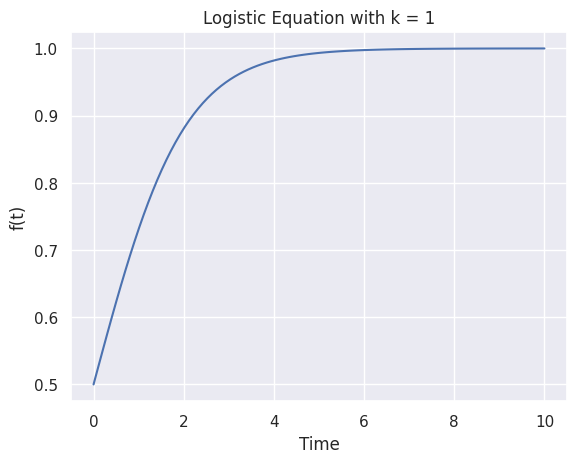

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the logistic equation function
def logistic_eq(f, t, k):
    return k * f * (1 - f)

# Initial condition
f0 = 0.5

# Time points
t = np.linspace(0, 10, 100)

# Solve the ODE
k = 1  # You can adjust the value of k as needed
f = odeint(logistic_eq, f0, t, args=(k,))

# Plot the solution
plt.plot(t, f)
plt.xlabel('Time')
plt.ylabel('f(t)')
plt.title('Logistic Equation with k = {}'.format(k))
plt.grid(True)
plt.show()
